In [41]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import seaborn as sns
import scipy.stats as st

# ALGORITMO DE PREDICCIÓN DE DESARROLLO DE DIABETES MELLITUS GESTACIONAL PARA WEARABLE

Este cuaderno es una continuación del 04-GDM-risk-prediction, porque hemos hecho un nuevo cuaderno donde nos hemos basado en los datos de synthe apara crear los datos del wearable y no crear los datos desde el MaternalHealth Risk, además, este algoritmo sólo se va a incluir las medidas directamente capturadas por el wearable. Factores como la edad o BMI no serán incluidas para las predicciones. 

In [45]:
data = pd.read_csv('Gestational-Diabetes-COMPLETE.csv')

In [47]:
data.columns

Index(['Age', 'No of Pregnancy', 'Gestation in previous Pregnancy', 'BMI',
       'HDL', 'Family History', 'unexplained prenetal loss',
       'Large Child or Birth Default', 'PCOS', 'Sys BP', 'Dia BP', 'OGTT',
       'Hemoglobin', 'Sedentary Lifestyle', 'Prediabetes',
       'Class Label(GDM /Non GDM)'],
      dtype='object')

In [49]:
data.drop(columns=['Age', 'No of Pregnancy', 'Gestation in previous Pregnancy', 'BMI', 'HDL', 'Family History', 'unexplained prenetal loss', 'Large Child or Birth Default', 'PCOS', 'Hemoglobin', 'Sedentary Lifestyle', 'Prediabetes'])

,Sys BP,Dia BP,OGTT,Class Label(GDM /Non GDM)
0,102.0,69,158.340759,0
1,101.0,63,94.553606,0
2,118.0,79,297.914461,0
3,99.0,70,150.847222,0
4,116.0,65,229.354507,0
...,...,...,...,...
3520,150.0,107,187.000000,1
3521,166.0,85,164.000000,1
3522,178.0,81,141.000000,1
3523,139.0,115,133.000000,0


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Model
from keras.layers import Input, Dense
# 1. Selección de las variables predictoras y objetivo
X = data[['Sys BP', 'Dia BP', 'OGTT']]  # Variables predictoras seleccionadas
y = data['Class Label(GDM /Non GDM)']  # Variable objetivo: GDM / non-GDM

# Dividimos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Construimos el autoencoder
input_dim = X_train.shape[1]  # Número de características
encoding_dim = 5  # Regla: dimensionalidad comprimida (puede ser ajustada)

# Modelo autoencoder:
input_layer = Input(shape=(input_dim, ))
encoded = Dense(16, activation='relu')(input_layer)  # Primera capa oculta
encoded = Dense(encoding_dim, activation='relu')(encoded)  # Capa comprimida
decoded = Dense(16, activation='relu')(encoded)  # Reconstrucción
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder completo
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# 3. Entrenamos el autoencoder
history = autoencoder.fit(
    X_train, X_train,  # El autoencoder trata de reconstruir las mismas entradas
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# 4. Extraer las características comprimidas del autoencoder
encoder = Model(inputs=input_layer, outputs=encoded)  # Modelo para codificar
X_train_encoded = encoder.predict(X_train)  # Características comprimidas del conjunto de entrenamiento
X_test_encoded = encoder.predict(X_test)  # Características comprimidas del conjunto de prueba

# 5. Entrenar el clasificador usando las características comprimidas
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_encoded, y_train)

# Predicción y evaluación del modelo
y_pred = classifier.predict(X_test_encoded)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 18944.9648 - val_loss: 19196.8359
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18673.4688 - val_loss: 19196.2715
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18692.1387 - val_loss: 19196.1582
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18698.0879 - val_loss: 19196.0859
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18783.6250 - val_loss: 19196.0625
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18706.0801 - val_loss: 19196.0488
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18718.4160 - val_loss: 19196.0410
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19009.6016 - val_loss: 19196.0332
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18895.5625 - val_loss: 19196.0293
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19005.4121 - val_loss: 19196.0254
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18743.1133 - val_los

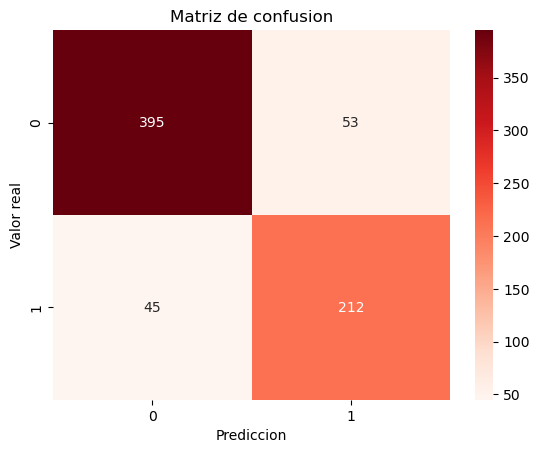

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt= 'd', cmap='Reds')
plt.xlabel('Prediccion')
plt.ylabel('Valor real')
plt.title('Matriz de confusion')
plt.show()

In [55]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(classifier, X_train_encoded, y_train, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean()}")

Cross-validation scores: [0.88475177 0.87234043 0.90602837 0.86170213 0.87411348]
Mean accuracy: 0.8797872340425531


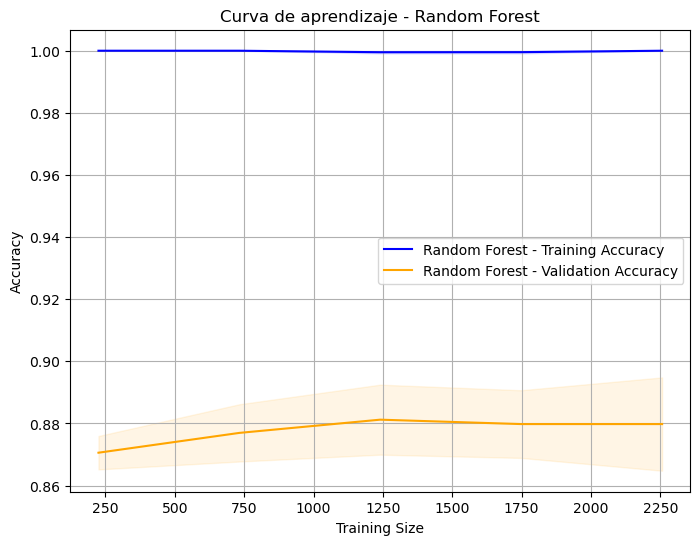

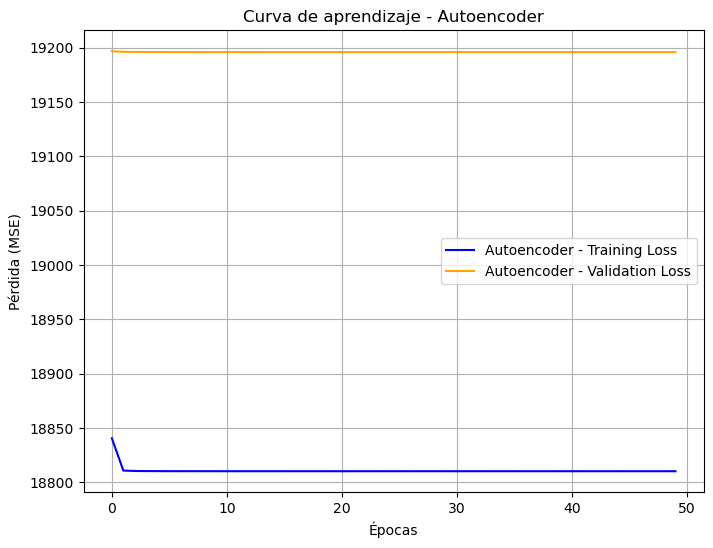

In [57]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# Learning curve para Random Forest Classifier
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(
    classifier, X_train_encoded, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Calcular medias y desviaciones estándar para Random Forest
train_mean_rf = np.mean(train_scores_rf, axis=1)
test_mean_rf = np.mean(test_scores_rf, axis=1)
train_std_rf = np.std(train_scores_rf, axis=1)
test_std_rf = np.std(test_scores_rf, axis=1)

# Graficar la curva de aprendizaje para Random Forest
plt.figure(figsize=(8, 6))
plt.plot(train_sizes_rf, train_mean_rf, label="Random Forest - Training Accuracy", color="blue")
plt.plot(train_sizes_rf, test_mean_rf, label="Random Forest - Validation Accuracy", color="orange")
plt.fill_between(train_sizes_rf, train_mean_rf - train_std_rf, train_mean_rf + train_std_rf, alpha=0.1, color="blue")
plt.fill_between(train_sizes_rf, test_mean_rf - test_std_rf, test_mean_rf + test_std_rf, alpha=0.1, color="orange")
plt.title("Curva de aprendizaje - Random Forest")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Learning curve para el autoencoder (usando pérdida como métrica)
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Autoencoder - Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Autoencoder - Validation Loss', color='orange')
plt.title('Curva de aprendizaje - Autoencoder')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid()
plt.show()

Dadas ambas gráficas, vemos que el modelo está overffited.

En la gráfica de Random Forest la accuracy en el entrenamiento permanece muy alta, y hay una gran diferencia respecto a la la accuracy en validación, que pese a que aumenta, nunca alcanza la precisión del entrenamiento, esto quiere decir que no generelaza, tiene capacidad suficiente para aprendere los datos y a la entrada de los nuevos no se ajusta bien. Una opción es limitar la profundidad (max_depth) de los árboles, ajustar el número de árboles (n_estimators) o la cantidad mínima para dividir un nodo (min_samples_split).

En la gráfica de Autoencoder, se muestra la evolución de la pérdida (MSE) durante el enytrenamiento del autoencoder para los conjuntos de entrenamiento y validación.
Podemos observar una pérdida constante y alta, tanto en validación como en entrenamiento rondan la franja de 11650-11900, lo que indica que el modelo no está aprendiendo adecuadamente, ya que no logra redicir la pérdida.

Puede deberse a una arquitectura inadecuada, el modelo podría ser demasiado simple o tener capas insuficientes para capturar la complejidad de los datos, o la tasa de aprendizaje inadecuada.

## BÚSQUEDA DE PARÁMETROS PARA MEJORAR LA PRECISIÓN DE LOS MODELOS

In [121]:
from sklearn.metrics import accuracy_score, classification_report

# Predicciones en el conjunto de entrenamiento
y_train_pred = best_rf_model.predict(X_train_encoded)

# Predicciones en el conjunto de prueba
y_test_pred = best_rf_model.predict(X_test_encoded)

# Calcular precisión
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Precisión en entrenamiento: {train_accuracy:.2f}")
print(f"Precisión en prueba: {test_accuracy:.2f}")

# Reporte de clasificación para el conjunto de prueba
print("\nReporte de clasificación en prueba:")
print(classification_report(y_test, y_test_pred))

Precisión en entrenamiento: 1.00
Precisión en prueba: 0.93

Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       448
           1       0.89      0.91      0.90       257

    accuracy                           0.93       705
   macro avg       0.92      0.93      0.92       705
weighted avg       0.93      0.93      0.93       705



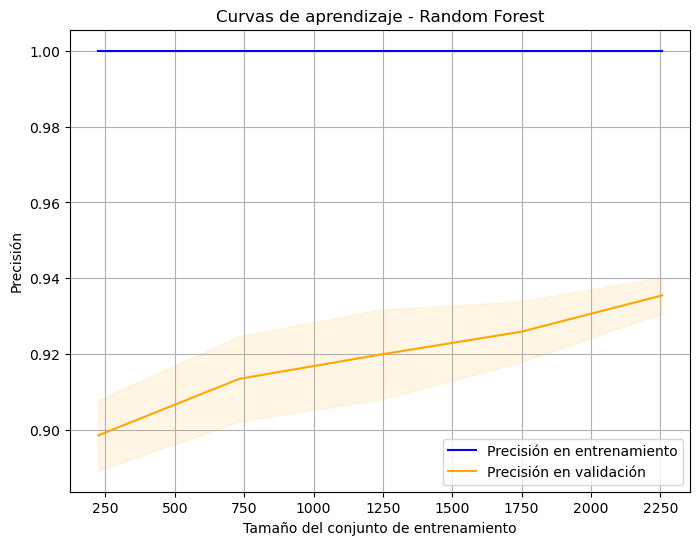

In [123]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generar las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    best_rf_model, X_train_encoded, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Calcular medias y desviaciones estándar
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Precisión en entrenamiento", color="blue")
plt.plot(train_sizes, test_mean, label="Precisión en validación", color="orange")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="orange")
plt.title("Curvas de aprendizaje - Random Forest")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.legend()
plt.grid()
plt.show()


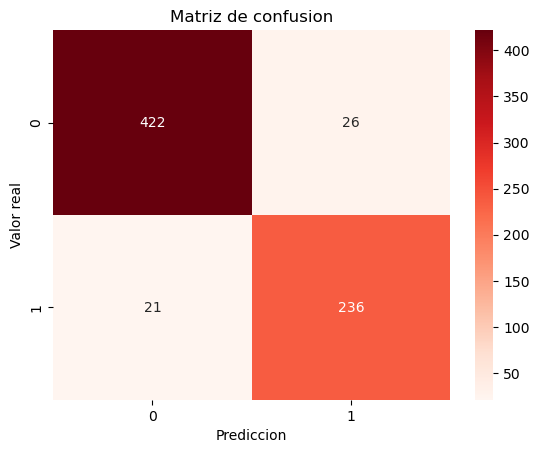

In [125]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt= 'd', cmap='Reds')
plt.xlabel('Prediccion')
plt.ylabel('Valor real')
plt.title('Matriz de confusion')
plt.show()

In [127]:
from joblib import dump, load

# Guardar el mejor modelo y parámetros
dump(best_rf_model, 'best_rf_model_WEARABLE.joblib')
dump(best_rf_params, 'best_rf_params_WEARABLE.joblib')

print("Modelo y parámetros guardados con joblib.")

Modelo y parámetros guardados con joblib.


Hacemos lo mismo para el autoencoder:

In [129]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Crear el autoencoder como función para KerasRegressor
def create_autoencoder(encoding_dim=4, hidden_dim=16, activation='relu', optimizer='adam'):
    input_dim = X_train.shape[1]  # Número de características de entrada

    # Construcción del autoencoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(hidden_dim, activation=activation)(input_layer)
    encoded = Dense(encoding_dim, activation=activation)(encoded)  # Capa comprimida
    decoded = Dense(hidden_dim, activation=activation)(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    # Modelo completo del autoencoder
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=optimizer, loss='mse')  # Usar MSE como pérdida
    return autoencoder

# Envuelve el modelo para usarlo con GridSearchCV
autoencoder_regressor = KerasRegressor(build_fn=create_autoencoder, verbose=0)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'model__encoding_dim': [2, 4, 8],
    'model__hidden_dim': [8, 16, 32],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'sgd'],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=autoencoder_regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Minimizar el error cuadrático medio
    cv=3,  # Validación cruzada de 3 pliegues
    verbose=2,
    n_jobs=-1
)

# Ajustar el GridSearchCV
grid_search.fit(X_train, X_train)  # Entradas y salidas son las mismas en un autoencoder

# Mejor modelo encontrado
best_autoencoder = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Mejores parámetros para el autoencoder:")
print(best_params)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


C:\Users\virginia.anton\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\virginia.anton\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\virginia.anton\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Mejores parámetros para el autoencoder:
{'batch_size': 16, 'epochs': 100, 'model__activation': 'relu', 'model__encoding_dim': 2, 'model__hidden_dim': 16, 'model__optimizer': 'adam'}


In [145]:
from keras.models import Model

# Reconstruir el modelo con los mejores parámetros
best_params = grid_search.best_params_
print("Mejores parámetros:", best_params)

# Crear el modelo del autoencoder
autoencoder = create_autoencoder(
    encoding_dim=4,
    hidden_dim=best_params['model__hidden_dim'],
    activation=best_params['model__activation'],
    optimizer=best_params['model__optimizer']
)

# Entrenar el modelo con los mejores parámetros
autoencoder.fit(
    X_train, X_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1
)

# Guardar el modelo completo del autoencoder
autoencoder.save("best_autoencoder_model_WEARABLE.keras")
print("Modelo del autoencoder completo guardado como 'best_autoencoder_model.keras'.")

# Extraer el encoder
input_layer = autoencoder.input
encoded_layer = autoencoder.layers[2].output  # Capa comprimida
encoder = Model(inputs=input_layer, outputs=encoded_layer)

encoder.save("best_encoder_model_WEARABLE.keras")
print("Modelo del encoder guardado como 'best_encoder_model.keras'.")

Mejores parámetros: {'batch_size': 16, 'epochs': 100, 'model__activation': 'relu', 'model__encoding_dim': 2, 'model__hidden_dim': 16, 'model__optimizer': 'adam'}
Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11929.4229
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11614.1914
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11727.9141
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11919.8643
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11547.1553
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11716.5938
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11639.5547
Epoch 8/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11769.5977
Epoch 9/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11700.2627
Epoch 10/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11699.7070
Epoch 11/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11838.9805
Epoch 12/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s

In [147]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(classifier, X_train_encoded, y_train, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean()}")

Cross-validation scores: [0.92907801 0.93262411 0.94148936 0.93794326 0.92553191]
Mean accuracy: 0.9333333333333333


In [177]:
import joblib
# Guardar clasificador Random Forest
joblib.dump(classifier, 'random_forest_classifie_WEARABLE.pkl')

# Guardar autoencoder completo
autoencoder.save('autoencoder_model_WEARABLE.h5')

# Guardar encoder (si lo necesitas)
encoder.save('encoder_model_WEARABLE.h5')

print("Modelos guardados correctamente.")

Modelos guardados correctamente.


# MEJOR MODELO

Vamos a probar el mismo modelo que para las el algoritmo predictor de los datasets de las consultas médicas

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
# 1. Selección de las variables predictoras y objetivo
X = data[['Sys BP', 'Dia BP', 'OGTT']]  # Variables predictoras seleccionadas
y = data['Class Label(GDM /Non GDM)']  # Variable objetivo: GDM / non-GDM

# Dividimos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Construimos el autoencoder
input_dim = X_train.shape[1]  # Número de características
encoding_dim = 10  # Regla: dimensionalidad comprimida (puede ser ajustada)

# Modelo autoencoder:
input_layer = Input(shape=(input_dim, ))
encoded = Dense(32, activation='relu', kernel_regularizer = l2(0.001))(input_layer)  # Primera capa oculta
#encoded = Dense(encoding_dim, activation='relu')(encoded)  # Capa comprimida
encoded =Dropout(0.2)(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)  # Reconstrucción
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder completo
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 3. Entrenamos el autoencoder
history = autoencoder.fit(
    X_train, X_train,  # El autoencoder trata de reconstruir las mismas entradas
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# 4. Extraer las características comprimidas del autoencoder
encoder = Model(inputs=input_layer, outputs=encoded)  # Modelo para codificar
X_train_encoded = encoder.predict(X_train)  # Características comprimidas del conjunto de entrenamiento
X_test_encoded = encoder.predict(X_test)  # Características comprimidas del conjunto de prueba

# 5. Entrenar el clasificador usando las características comprimidas
classifier = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=20, min_samples_leaf=10, max_features='sqrt', class_weight='balanced', random_state=42)
classifier.fit(X_train_encoded, y_train)

# Predicción y evaluación del modelo
y_pred = classifier.predict(X_test_encoded)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Epoch 1/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19057.7402 - val_loss: 19196.0137
Epoch 2/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18694.6660 - val_loss: 19196.0117
Epoch 3/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18860.0254 - val_loss: 19196.0117
Epoch 4/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18693.3906 - val_loss: 19196.0117
Epoch 5/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19056.8711 - val_loss: 19196.0117
Epoch 6/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18997.2734 - val_loss: 19196.0117
Epoch 7/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18753.7031 - val_loss: 19196.0117
Epoch 8/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18782.3184 - val_loss: 19196.0117
Epoch 9/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18921.5039 - val_loss: 19196.0117
Epoch 10/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18847.2480 - val_loss: 19196.0117
Epoch 11/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18829.531

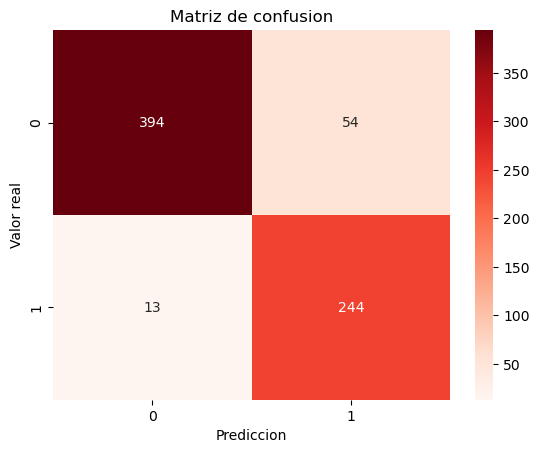

In [103]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt= 'd', cmap='Reds')
plt.xlabel('Prediccion')
plt.ylabel('Valor real')
plt.title('Matriz de confusion')
plt.show()

In [105]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(classifier, X_train_encoded, y_train, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean()}")

Cross-validation scores: [0.92375887 0.91666667 0.92553191 0.92198582 0.91843972]
Mean accuracy: 0.9212765957446809


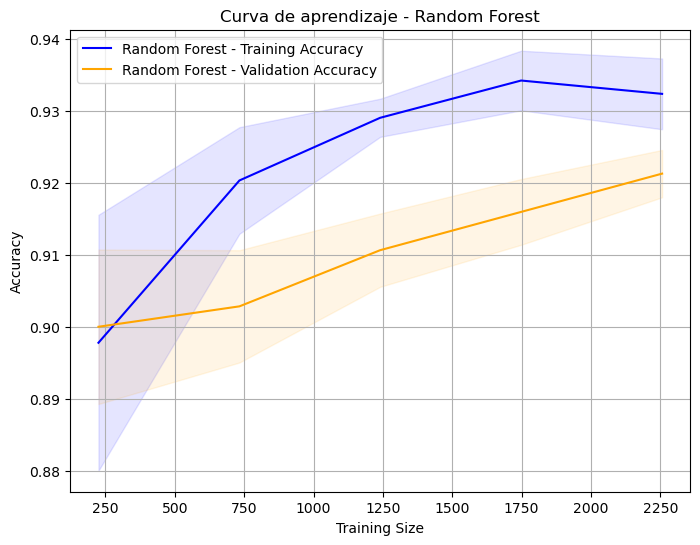

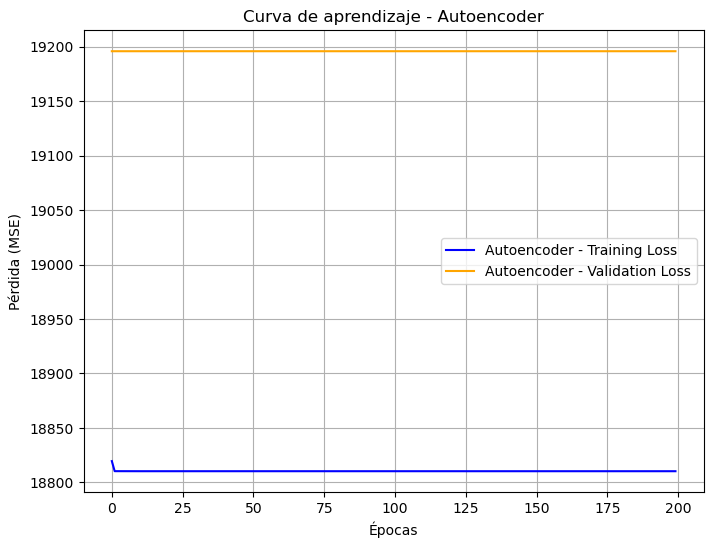

In [107]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# Learning curve para Random Forest Classifier
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(
    classifier, X_train_encoded, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Calcular medias y desviaciones estándar para Random Forest
train_mean_rf = np.mean(train_scores_rf, axis=1)
test_mean_rf = np.mean(test_scores_rf, axis=1)
train_std_rf = np.std(train_scores_rf, axis=1)
test_std_rf = np.std(test_scores_rf, axis=1)

# Graficar la curva de aprendizaje para Random Forest
plt.figure(figsize=(8, 6))
plt.plot(train_sizes_rf, train_mean_rf, label="Random Forest - Training Accuracy", color="blue")
plt.plot(train_sizes_rf, test_mean_rf, label="Random Forest - Validation Accuracy", color="orange")
plt.fill_between(train_sizes_rf, train_mean_rf - train_std_rf, train_mean_rf + train_std_rf, alpha=0.1, color="blue")
plt.fill_between(train_sizes_rf, test_mean_rf - test_std_rf, test_mean_rf + test_std_rf, alpha=0.1, color="orange")
plt.title("Curva de aprendizaje - Random Forest")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Learning curve para el autoencoder (usando pérdida como métrica)
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Autoencoder - Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Autoencoder - Validation Loss', color='orange')
plt.title('Curva de aprendizaje - Autoencoder')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid()
plt.show()

Hemos mejorado el sobreajuste, ya que hay una diferencia entre las curvas de 0.02-0.03, y por tanto podemos aceptar el modelo.

In [110]:
# Guardar el modelo Autoencoder en formato .h5
autoencoder.save("best_autoencoder_model_wearable.h5")

# Guardar solo el encoder para futuras transformaciones
encoder.save("best_ncoder_model_wearable.h5")


In [112]:
import joblib

# Guardar el modelo Random Forest
joblib.dump(classifier, "best_random_forest_classifier.pkl")

['best_random_forest_classifier.pkl']

<h3>CARGAMOS MODELO</h3>

In [115]:
from keras.models import load_model
from keras.losses import MeanSquaredError

import joblib

encoder_loaded = load_model("best_ncoder_model_wearable.h5")
autoencoder_loaded = load_model("best_autoencoder_model_wearable.h5", custom_objects={'mse': MeanSquaredError()})
# Cargar el clasificador Random Forest
classifier_loaded = joblib.load("best_random_forest_classifier.pkl")


## PRUEBA DATOS WEARABLE

In [180]:
wearabledf = pd.read_csv("wearable_MaternalRiskDatasetUnknownAge.csv")

In [182]:
wearabledf_aux = wearabledf.copy()

In [184]:
cols_to_drop = ['PATIENT', 'DATE', 'TRIMESTER', 'BMI', 'BodyTemperature', 'HeartRate']
wearabledf_aux= wearabledf_aux.drop(cols_to_drop, axis=1)

In [188]:
#Renombramos columnas
column_rename_mapping = {
    'Glucose': 'OGTT',
    'SBP': 'Sys BP',
    'DBP': 'Dia BP', 
}
wearabledf_aux = wearabledf_aux.rename(columns=column_rename_mapping)
print(wearabledf_aux.columns)

Index(['Dia BP', 'OGTT', 'Sys BP'], dtype='object')


In [190]:
#Renombramos columnas
column_rename_mapping = {
    'Glucose': 'OGTT',
    'SBP': 'Sys BP',
    'DBP': 'Dia BP', 
}
wearabledf = wearabledf.rename(columns=column_rename_mapping)
print(wearabledf.columns)

Index(['PATIENT', 'DATE', 'BMI', 'Dia BP', 'OGTT', 'HeartRate', 'Sys BP',
       'TRIMESTER', 'BodyTemperature'],
      dtype='object')


In [194]:
# 3. Generar representaciones comprimidas con el encoder
compressed_wearable_aux = encoder_loaded.predict(wearabledf_aux)

# 4. Usar el modelo Random Forest para predecir con los datos comprimidos
predictions = classifier_loaded.predict(compressed_wearable_aux)
print("Predicciones realizadas con Random Forest.")

# 5. Mostrar las predicciones
print("Predicciones de clase para los datos nuevos:")
print(predictions)

8921/8921 ━━━━━━━━━━━━━━━━━━━━ 6s 724us/step
Predicciones realizadas con Random Forest.
Predicciones de clase para los datos nuevos:
[0 0 0 ... 0 0 0]


In [198]:
# Crear un DataFrame con las predicciones
  # Copia los datos originales
wearabledf['Predicted Target'] = predictions  # Agregar las predicciones

# Mostrar las primeras filas
print(wearabledf.head())


                                PATIENT                       DATE   BMI  \
0  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-10 10:34:58+00:00  24.7   
1  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-10 18:34:58+00:00  24.7   
2  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-11 02:34:58+00:00  24.7   
3  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-11 10:34:58+00:00  24.7   
4  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-11 18:34:58+00:00  24.7   

      Dia BP       OGTT   HeartRate      Sys BP  TRIMESTER  BodyTemperature  \
0  71.178908  79.831179  114.838581  100.268811          1        37.374863   
1  65.962812  74.859087  108.726190   92.726731          1        37.396294   
2  70.005049  82.893106  114.925831  100.203023          1        37.305957   
3  71.682904  83.399110  116.286471  101.138374          1        37.364837   
4  62.492963  74.590061  106.666019   90.652381          1        37.322765   

   Predicted Target  
0                 0  
1                 0  
2 

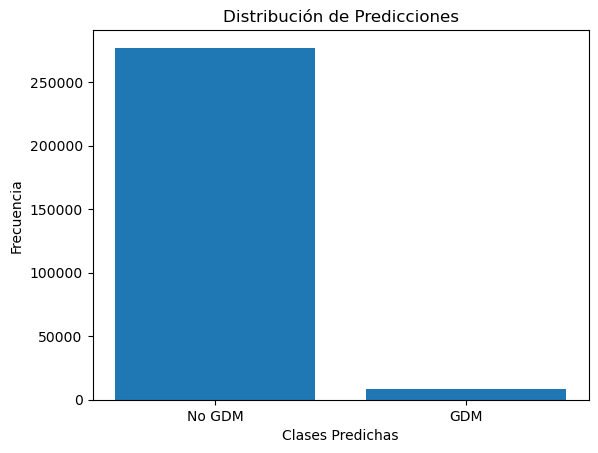

In [200]:
import matplotlib.pyplot as plt

# Conteo de predicciones
newpred_counts = wearabledf['Predicted Target'].value_counts()
labels = newpred_counts.index.astype(str)
# Gráfico de barras
plt.bar(labels, newpred_counts.values)
plt.title('Distribución de Predicciones')
plt.xlabel('Clases Predichas')
plt.ylabel('Frecuencia')
plt.xticks(ticks=labels, labels=['No GDM', 'GDM'])
plt.show()

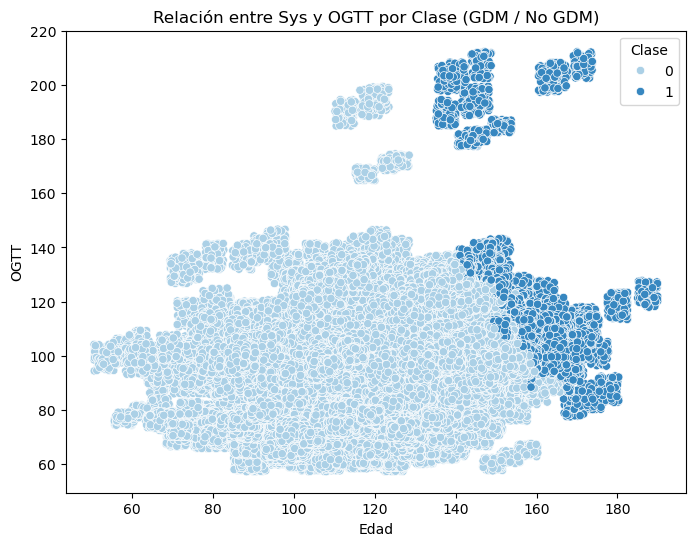

In [202]:
# Crear un gráfico de dispersión entre Edad y OGTT, coloreado por clase
plt.figure(figsize=(8, 6))
sns.scatterplot(x=wearabledf['Sys BP'], y=wearabledf['OGTT'], hue=wearabledf['Predicted Target'], palette='Blues')
plt.title('Relación entre Sys y OGTT por Clase (GDM / No GDM)')
plt.xlabel('Edad')
plt.ylabel('OGTT')
plt.legend(title='Clase')
plt.show()

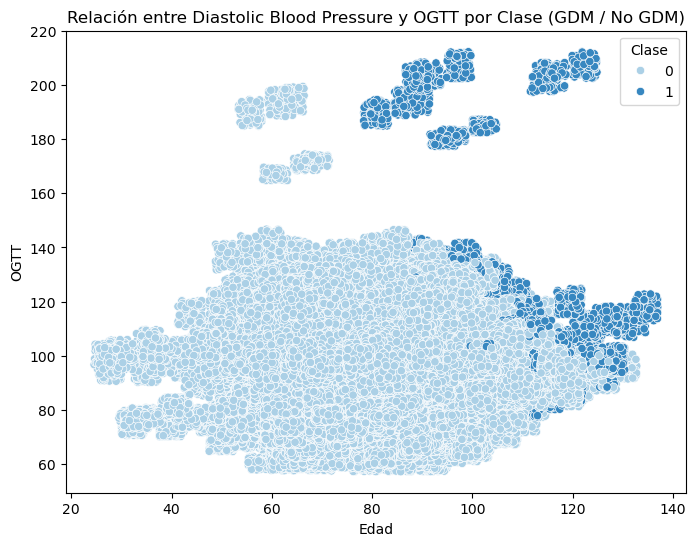

In [134]:
# Crear un gráfico de dispersión entre Edad y OGTT, coloreado por clase
plt.figure(figsize=(8, 6))
sns.scatterplot(x=newpredictions_df['Dia BP'], y=newpredictions_df['OGTT'], hue=newpredictions_df['Predicted Target'], palette='Blues')
plt.title('Relación entre Diastolic Blood Pressure y OGTT por Clase (GDM / No GDM)')
plt.xlabel('Edad')
plt.ylabel('OGTT')
plt.legend(title='Clase')
plt.show()

In [204]:
wearabledf.to_csv('wearableUnknownAge_PREDICTIONS.csv', index=False)

# PRUEBA CON DATASET WEARABLE CASO LÍMITE CASOS DE PREECLAMPSIA Y DIABETES GESTACIONAL

In [137]:
extremeCase = pd.read_csv('wearable_MaternalRiskDataset_EXTREME_CASE.csv')

In [139]:
extremeCase

,PATIENT,DATE,BMI,DBP,Glucose,HeartRate,SBP,TRIMESTER,BodyTemperature
0,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-10 10:34:58+00:00,24.7,71.178908,79.831179,114.838581,100.268811,1,37.374863
1,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-10 18:34:58+00:00,24.7,65.962812,74.859087,108.726190,92.726731,1,37.396294
2,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 02:34:58+00:00,24.7,70.005049,82.893106,114.925831,100.203023,1,37.305957
3,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 10:34:58+00:00,24.7,71.682904,83.399110,116.286471,101.138374,1,37.364837
4,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 18:34:58+00:00,24.7,62.492963,74.590061,106.666019,90.652381,1,37.322765
...,...,...,...,...,...,...,...,...,...
285467,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-15 21:49:39+00:00,24.8,86.715237,118.954019,111.153341,126.668632,3,37.091396
285468,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-16 05:49:39+00:00,24.8,95.012159,119.079043,120.751634,133.532145,3,36.857251
285469,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-16 13:49:39+00:00,24.8,93.703150,117.198304,111.686933,127.233104,3,37.072783
285470,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-16 21:49:39+00:00,24.8,87.916110,119.355192,111.534658,125.608165,3,37.136600


In [141]:
cols_to_drop = ['PATIENT', 'DATE', 'TRIMESTER', 'BMI', 'BodyTemperature', 'HeartRate']
extremeCase = extremeCase .drop(cols_to_drop, axis=1)

In [143]:
#Renombramos columnas
column_rename_mapping = {
    'Glucose': 'OGTT',
    'SBP': 'Sys BP',
    'DBP': 'Dia BP'
}
extremeCase = extremeCase.rename(columns=column_rename_mapping)
print(extremeCase.columns)

Index(['Dia BP', 'OGTT', 'Sys BP'], dtype='object')


In [147]:
# 3. Generar representaciones comprimidas con el encoder
compressed_extremeCase = encoder_loaded.predict(extremeCase)

# 4. Usar el modelo Random Forest para predecir con los datos comprimidos
predictions = classifier_loaded.predict(compressed_extremeCase)
print("Predicciones realizadas con Random Forest.")

# 5. Mostrar las predicciones
print("Predicciones de clase para los datos nuevos:")
print(predictions)

8921/8921 ━━━━━━━━━━━━━━━━━━━━ 3s 354us/step
Predicciones realizadas con Random Forest.
Predicciones de clase para los datos nuevos:
[0 0 0 ... 0 0 0]


In [149]:
# Crear un DataFrame con las predicciones
predictionsExtremeCase = extremeCase.copy()  # Copia los datos originales
predictionsExtremeCase['Predicted Target'] = predictions  # Agregar las predicciones

# Mostrar las primeras filas
print(predictionsExtremeCase.head())

      Dia BP       OGTT      Sys BP  Predicted Target
0  71.178908  79.831179  100.268811                 0
1  65.962812  74.859087   92.726731                 0
2  70.005049  82.893106  100.203023                 0
3  71.682904  83.399110  101.138374                 0
4  62.492963  74.590061   90.652381                 0


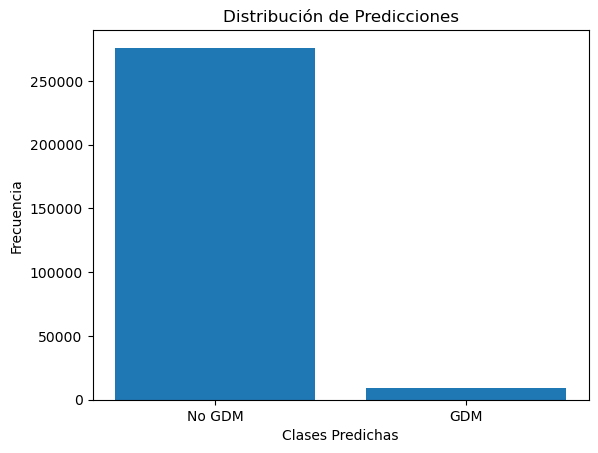

In [151]:
import matplotlib.pyplot as plt

# Conteo de predicciones
newpred_counts = predictionsExtremeCase['Predicted Target'].value_counts()

# Gráfico de barras
plt.bar(newpred_counts.index, newpred_counts.values, tick_label=['No GDM', 'GDM'])
plt.title('Distribución de Predicciones')
plt.xlabel('Clases Predichas')
plt.ylabel('Frecuencia')
plt.show()

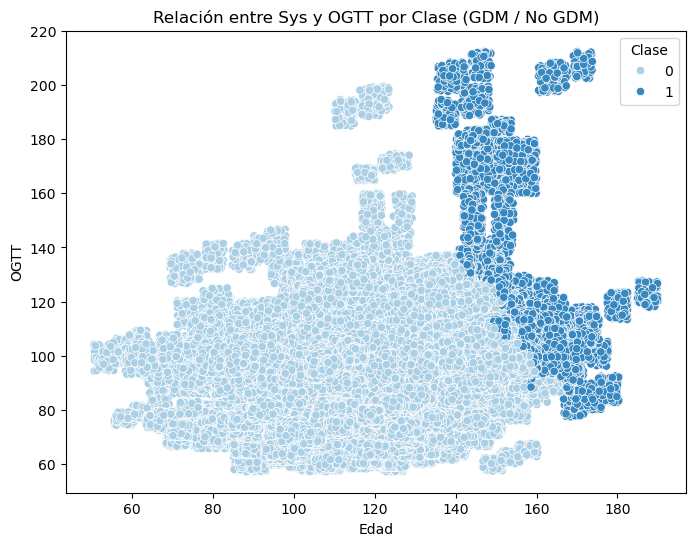

In [153]:
# Crear un gráfico de dispersión entre Edad y OGTT, coloreado por clase
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictionsExtremeCase['Sys BP'], y=predictionsExtremeCase['OGTT'], hue=predictionsExtremeCase['Predicted Target'], palette='Blues')
plt.title('Relación entre Sys y OGTT por Clase (GDM / No GDM)')
plt.xlabel('Edad')
plt.ylabel('OGTT')
plt.legend(title='Clase')
plt.show()

# PRUEBA CON UN DATASET CON SÓLO MUJERES CON GDM 
En el anterior caso, hemos mezclado mujeres con preeclampsia y diabetes gestacional, asignadas de forma aleatoria. Ahora, vamos a probar con un 70 % de mujeres con GDM para comporbar si el modelo es capaz de reconocer a esa cantidad de pacientes. 

In [159]:
gdmPatients = pd.read_csv('wearable_MaternalRiskDataset_MODIFIED.csv')

In [161]:
gdmPatients

,PATIENT,DATE,BMI,DBP,Glucose,HeartRate,SBP,TRIMESTER,BodyTemperature
0,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-10 10:34:58+00:00,24.7,71.178908,143.696122,114.838581,100.268811,1,37.374863
1,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-10 18:34:58+00:00,24.7,65.962812,134.746357,108.726190,92.726731,1,37.396294
2,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 02:34:58+00:00,24.7,70.005049,149.207591,114.925831,100.203023,1,37.305957
3,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 10:34:58+00:00,24.7,71.682904,150.118399,116.286471,101.138374,1,37.364837
4,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 18:34:58+00:00,24.7,62.492963,134.262110,106.666019,90.652381,1,37.322765
...,...,...,...,...,...,...,...,...,...
285467,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-15 21:49:39+00:00,24.8,86.715237,118.954019,111.153341,126.668632,3,37.091396
285468,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-16 05:49:39+00:00,24.8,95.012159,119.079043,120.751634,133.532145,3,36.857251
285469,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-16 13:49:39+00:00,24.8,93.703150,117.198304,111.686933,127.233104,3,37.072783
285470,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-16 21:49:39+00:00,24.8,87.916110,119.355192,111.534658,125.608165,3,37.136600


In [163]:
cols_to_drop = ['PATIENT', 'DATE', 'TRIMESTER', 'BMI', 'BodyTemperature', 'HeartRate']
gdmPatients = gdmPatients.drop(cols_to_drop, axis=1)

In [165]:
#Renombramos columnas
column_rename_mapping = {
    'Glucose': 'OGTT',
    'SBP': 'Sys BP',
    'DBP': 'Dia BP'
}
gdmPatients = gdmPatients.rename(columns=column_rename_mapping)
print(gdmPatients.columns)

Index(['Dia BP', 'OGTT', 'Sys BP'], dtype='object')


In [167]:
# 3. Generar representaciones comprimidas con el encoder
compressed_gdmPatients = encoder_loaded.predict(gdmPatients)

# 4. Usar el modelo Random Forest para predecir con los datos comprimidos
predictions = classifier_loaded.predict(compressed_gdmPatients)
print("Predicciones realizadas con Random Forest.")

# 5. Mostrar las predicciones
print("Predicciones de clase para los datos nuevos:")
print(predictions)

8921/8921 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step
Predicciones realizadas con Random Forest.
Predicciones de clase para los datos nuevos:
[0 0 0 ... 0 0 0]


In [169]:
# Crear un DataFrame con las predicciones
predictionsgdmPatients = gdmPatients.copy()  # Copia los datos originales
predictionsgdmPatients['Predicted Target'] = predictions  # Agregar las predicciones

# Mostrar las primeras filas
print(predictionsgdmPatients.head())

      Dia BP        OGTT      Sys BP  Predicted Target
0  71.178908  143.696122  100.268811                 0
1  65.962812  134.746357   92.726731                 0
2  70.005049  149.207591  100.203023                 0
3  71.682904  150.118399  101.138374                 0
4  62.492963  134.262110   90.652381                 0


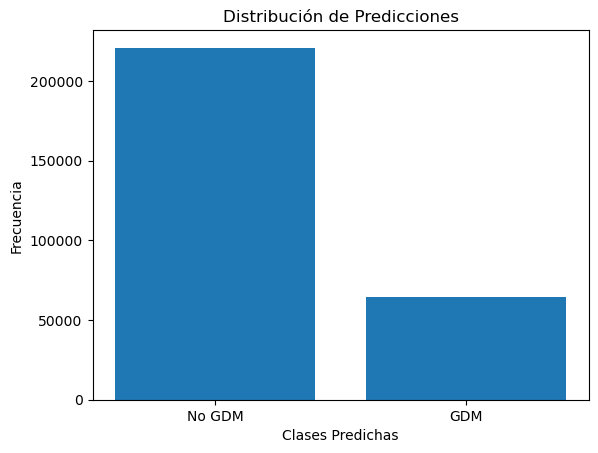

In [173]:
import matplotlib.pyplot as plt

# Conteo de predicciones
newpred_counts = predictionsgdmPatients['Predicted Target'].value_counts()

# Gráfico de barras
plt.bar(newpred_counts.index, newpred_counts.values, tick_label=['No GDM', 'GDM'])
plt.title('Distribución de Predicciones')
plt.xlabel('Clases Predichas')
plt.ylabel('Frecuencia')
plt.show()

Vemos que pese a forzar a habe run número alto de mujres con GDM el modelo no lo recnoce muy bien, y sacamos las siguientes conclusiones: 
<h4>1. Desbalanece en la variable objetivo o etiqueta mal representada:</h4>
<p>Aunque haya muchas mujeres con glucosa alta, no significa que tengan GDM.</p>
<h4>2. Sesgo en el entrenamiento del modelo:</h4>
<p>Si el dataset de entrenamiento tiene una distribución diferente de la glucosa ensangre respecto al dataset de prueba, el modelo puedde haber aprendido reglas que no generalizan bien.</p>
<h4>3. Importancia de variables sesgada</h4>
<p>Si el modelo da más peso a la presión arterial que a la glucosa en sangre, es posible que esté ignorndo el factor más relevante para diagnosticar GDM.</p>
<h4>4. Sobreajuste:</h4>
<p>Puede que ser que sólo tres parámetros sean demasiado pocos y el modelo no captura bien la relación entre variables y las clases GDM.</p>

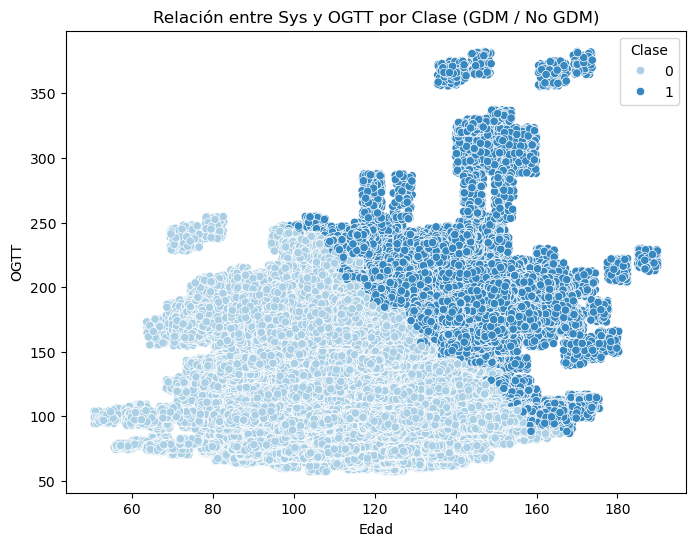

In [175]:
# Crear un gráfico de dispersión entre Edad y OGTT, coloreado por clase
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictionsgdmPatients['Sys BP'], y=predictionsgdmPatients['OGTT'], hue=predictionsgdmPatients['Predicted Target'], palette='Blues')
plt.title('Relación entre Sys y OGTT por Clase (GDM / No GDM)')
plt.xlabel('Edad')
plt.ylabel('OGTT')
plt.legend(title='Clase')
plt.show()